<a href="https://colab.research.google.com/github/gopalkalpande/Social-Network-Graph-Link-Prediction-Facebook-Challenge/blob/master/FB_model_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!ls '/content/drive/My Drive/Applied AI/Facebook Friend Recommendation using Graph Mining'

data			  storage_sample_stage2.h5
FB_EDA.ipynb		  xgb_clf1.pickle.dat
FB_featurization.ipynb	  xgb_clf.pickle.dat
FB_Models.ipynb		  xgb_fine_tuned_clf1.pickle.dat
storage_sample_stage1.h5  xgb_fine_tuned_clf.pickle.dat


In [0]:
if os.path.isfile('/content/drive/My Drive/Applied AI/Facebook Friend Recommendation using Graph Mining/data/after_eda/train_pos_after_eda.csv'):
    train_graph=nx.read_edgelist('/content/drive/My Drive/Applied AI/Facebook Friend Recommendation using Graph Mining/data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
else:
    print("please run the FB_EDA.ipynb or download the files from drive")

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


In [0]:
import random
if os.path.isfile('/content/drive/My Drive/Applied AI/Facebook Friend Recommendation using Graph Mining/data/after_eda/train_after_eda.csv'):
    filename = "/content/drive/My Drive/Applied AI/Facebook Friend Recommendation using Graph Mining/data/after_eda/train_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 15100030
    # n_train = sum(1 for line in open(filename)) #number of records in file (excludes header)
    
    n_train =  15100028
    s = 100000 #desired sample size
    skip_train = sorted(random.sample(range(1,n_train+1),n_train-s))
    #https://stackoverflow.com/a/22259008/4084039
    print('Hi!')

Hi!


In [0]:
if os.path.isfile('/content/drive/My Drive/Applied AI/Facebook Friend Recommendation using Graph Mining/data/after_eda/train_after_eda.csv'):
    filename = "/content/drive/My Drive/Applied AI/Facebook Friend Recommendation using Graph Mining/data/after_eda/test_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 3775008
    # n_test = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_test = 3775006
    s = 50000 #desired sample size
    skip_test = sorted(random.sample(range(1,n_test+1),n_test-s))
    #https://stackoverflow.com/a/22259008/4084039
    print('Hi!')

Hi!


In [0]:
print("Number of rows in the train data file:", n_train)
print("Number of rows we are going to elimiate in train data are",len(skip_train))
print("Number of rows in the test data file:", n_test)
print("Number of rows we are going to elimiate in test data are",len(skip_test))

Number of rows in the train data file: 15100028
Number of rows we are going to elimiate in train data are 15000028
Number of rows in the test data file: 3775006
Number of rows we are going to elimiate in test data are 3725006


In [0]:
df_final_train = pd.read_csv('/content/drive/My Drive/Applied AI/Facebook Friend Recommendation using Graph Mining/data/after_eda/train_after_eda.csv', skiprows=skip_train, names=['source_node', 'destination_node'])
df_final_train['indicator_link'] = pd.read_csv('/content/drive/My Drive/Applied AI/Facebook Friend Recommendation using Graph Mining/data/train_y.csv', skiprows=skip_train, names=['indicator_link'])
print("Our train matrix size ",df_final_train.shape)
df_final_train.head(2)

Our train matrix size  (100002, 3)


,source_node,destination_node,indicator_link
0,273084,1505602,1
1,333578,879520,1


In [0]:
df_final_test = pd.read_csv('/content/drive/My Drive/Applied AI/Facebook Friend Recommendation using Graph Mining/data/after_eda/test_after_eda.csv', skiprows=skip_test, names=['source_node', 'destination_node'])
df_final_test['indicator_link'] = pd.read_csv('/content/drive/My Drive/Applied AI/Facebook Friend Recommendation using Graph Mining/data/test_y.csv', skiprows=skip_test, names=['indicator_link'])
print("Our test matrix size ",df_final_test.shape)
df_final_test.head(2)

Our test matrix size  (50002, 3)


,source_node,destination_node,indicator_link
0,848424,784690,1
1,1191790,1255126,1


In [0]:
def compute_features_stage1(df_final):
    #calculating no of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    for i,row in df_final.iterrows():
        try:
            s1=set(train_graph.predecessors(row['source_node']))
            s2=set(train_graph.successors(row['source_node']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(train_graph.predecessors(row['destination_node']))
            d2=set(train_graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))
        print(d2)

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees

In [0]:
if not os.path.isfile('/content/drive/My Drive/Applied AI/Facebook Friend Recommendation using Graph Mining/storage_sample_stage1.h5'):
    print('start')
    df_final_train['num_followers_s'], df_final_train['num_followers_d'], \
    df_final_train['num_followees_s'], df_final_train['num_followees_d'], \
    df_final_train['inter_followers'], df_final_train['inter_followees']= compute_features_stage1(df_final_train)
    
    df_final_test['num_followers_s'], df_final_test['num_followers_d'], \
    df_final_test['num_followees_s'], df_final_test['num_followees_d'], \
    df_final_test['inter_followers'], df_final_test['inter_followees']= compute_features_stage1(df_final_test)
    
    hdf = HDFStore('/content/drive/My Drive/Applied AI/Facebook Friend Recommendation using Graph Mining/storage_sample_stage1.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
    print('end')
else:
    df_final_train = read_hdf('data/fea_sample/storage_sample_stage1.h5', 'train_df',mode='r')
    df_final_test = read_hdf('data/fea_sample/storage_sample_stage1.h5', 'test_df',mode='r')

In [0]:
from pandas import read_hdf
df_final_train = read_hdf('/content/drive/My Drive/Applied AI/Facebook Friend Recommendation using Graph Mining/storage_sample_stage1.h5', 'train_df',mode='r')
df_final_test = read_hdf('/content/drive/My Drive/Applied AI/Facebook Friend Recommendation using Graph Mining/storage_sample_stage1.h5', 'test_df',mode='r')

In [0]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link', 'num_followers_s',
       'num_followers_d', 'num_followees_s', 'num_followees_d',
       'inter_followers', 'inter_followees'],
      dtype='object')

In [0]:
from pandas import read_hdf
df_final_train = read_hdf('/content/drive/My Drive/Applied AI/Facebook Friend Recommendation using Graph Mining/data/fea_sample/storage_sample_stage1.h5', 'train_df',mode='r')
df_final_test = read_hdf('/content/drive/My Drive/Applied AI/Facebook Friend Recommendation using Graph Mining/data/fea_sample/storage_sample_stage1.h5', 'test_df',mode='r')
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees'],
      dtype='object')

In [0]:
from pandas import read_hdf
df_final_train = read_hdf('/content/drive/My Drive/Applied AI/Facebook Friend Recommendation using Graph Mining/storage_sample_stage1.h5', 'train_df',mode='r')
df_final_test = read_hdf('/content/drive/My Drive/Applied AI/Facebook Friend Recommendation using Graph Mining/storage_sample_stage1.h5', 'test_df',mode='r')

In [0]:
df_final_train.head()

,source_node,destination_node,indicator_link,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees
0,273084,1505602,1,11,6,15,8,0,0
1,333578,879520,1,1,2,3,1,0,1
2,679765,1773023,1,7,8,5,5,5,2
3,605761,1236701,1,9,2,14,1,0,1
4,542584,1431345,1,6,36,43,27,3,19


In [0]:
df_final_train['Preferential_Attachment'] = df_final_train.num_followers_s * df_final_train.num_followers_d
df_final_train.head()

,source_node,destination_node,indicator_link,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,Preferential_Attachment
0,273084,1505602,1,11,6,15,8,0,0,66
1,333578,879520,1,1,2,3,1,0,1,2
2,679765,1773023,1,7,8,5,5,5,2,56
3,605761,1236701,1,9,2,14,1,0,1,18
4,542584,1431345,1,6,36,43,27,3,19,216


In [0]:
df_final_test['Preferential_Attachment'] = df_final_test.num_followers_s * df_final_test.num_followers_d


In [0]:
hdf = HDFStore('/content/drive/My Drive/Applied AI/Facebook Friend Recommendation using Graph Mining/storage_sample_stage1.h5')
hdf.put('train_df',df_final_train, format='table', data_columns=True)
hdf.put('test_df',df_final_test, format='table', data_columns=True)
hdf.close()
print('Closed')

Closed


In [0]:
from pandas import read_hdf
df_final_train1 = read_hdf('/content/drive/My Drive/Applied AI/Facebook Friend Recommendation using Graph Mining/data/fea_sample/storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test1 = read_hdf('/content/drive/My Drive/Applied AI/Facebook Friend Recommendation using Graph Mining/data/fea_sample/storage_sample_stage4.h5', 'test_df',mode='r')
df_final_train1.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [0]:
df_final_train1['Preferential_Attachment'] = df_final_train.Preferential_Attachment
df_final_test1['Preferential_Attachment'] = df_final_test.Preferential_Attachment
df_final_train1.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'Preferential_Attachment'],
      dtype='object')

In [0]:
df_final_train1['svd_dot_1'] = df_final_train1.svd_u_s_1 * df_final_train1.svd_u_d_1
df_final_train1['svd_dot_2'] = df_final_train1.svd_u_s_2 * df_final_train1.svd_u_d_2
df_final_train1['svd_dot_3'] = df_final_train1.svd_u_s_3 * df_final_train1.svd_u_d_3
df_final_train1['svd_dot_4'] = df_final_train1.svd_u_s_4 * df_final_train1.svd_u_d_4
df_final_train1['svd_dot_5'] = df_final_train1.svd_u_s_5 * df_final_train1.svd_u_d_5
df_final_train1['svd_dot_6'] = df_final_train1.svd_u_s_6 * df_final_train1.svd_u_d_6

df_final_train1.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'Preferential_Attachment', 'svd_dot_1', 'svd_dot_2', 'svd_dot_3',
       'svd_dot_4', 'svd_dot_5', 'svd_dot_6'],
      dtype

In [0]:
df_final_test1['svd_dot_1'] = df_final_test1.svd_u_s_1 * df_final_test1.svd_u_d_1
df_final_test1['svd_dot_2'] = df_final_test1.svd_u_s_2 * df_final_test1.svd_u_d_2
df_final_test1['svd_dot_3'] = df_final_test1.svd_u_s_3 * df_final_test1.svd_u_d_3
df_final_test1['svd_dot_4'] = df_final_test1.svd_u_s_4 * df_final_test1.svd_u_d_4
df_final_test1['svd_dot_5'] = df_final_test1.svd_u_s_5 * df_final_test1.svd_u_d_5
df_final_test1['svd_dot_6'] = df_final_test1.svd_u_s_6 * df_final_test1.svd_u_d_6

df_final_test1.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'Preferential_Attachment', 'svd_dot_1', 'svd_dot_2', 'svd_dot_3',
       'svd_dot_4', 'svd_dot_5', 'svd_dot_6'],
      dtype

In [0]:
hdf = HDFStore('/content/drive/My Drive/Applied AI/Facebook Friend Recommendation using Graph Mining/storage_sample_stage2.h5')
hdf.put('train_df',df_final_train1, format='table', data_columns=True)
hdf.put('test_df',df_final_test1, format='table', data_columns=True)
hdf.close()
print('Closed')

Closed


In [0]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from pandas import read_hdf

In [0]:

df_final_train = read_hdf('/content/drive/My Drive/Applied AI/Facebook Friend Recommendation using Graph Mining/storage_sample_stage2.h5', 'train_df',mode='r')
df_final_test = read_hdf('/content/drive/My Drive/Applied AI/Facebook Friend Recommendation using Graph Mining/storage_sample_stage2.h5', 'test_df',mode='r')


In [6]:
df_final_train.columns


Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'Preferential_Attachment', 'svd_dot_1', 'svd_dot_2', 'svd_dot_3',
       'svd_dot_4', 'svd_dot_5', 'svd_dot_6'],
      dtype

In [7]:
df_final_test.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'Preferential_Attachment', 'svd_dot_1', 'svd_dot_2', 'svd_dot_3',
       'svd_dot_4', 'svd_dot_5', 'svd_dot_6'],
      dtype

In [8]:
df_final_train = df_final_train.drop(['svd_dot_1', 'svd_dot_2', 'svd_dot_3', 'svd_dot_4', 'svd_dot_5', 'svd_dot_6'], axis = 1)
df_final_test = df_final_test.drop(['svd_dot_1', 'svd_dot_2', 'svd_dot_3', 'svd_dot_4', 'svd_dot_5', 'svd_dot_6'], axis = 1)
df_final_train.shape, df_final_test.shape

((100002, 55), (50002, 55))

# Updated svd dot product

In [9]:
a = df_final_train.iloc[:, 30:36].values
b = df_final_train.iloc[:, 36:42].values
c = df_final_train.iloc[:, 42:48].values
d = df_final_train.iloc[:, 48:54].values
a.shape, b.shape, c.shape, d.shape

((100002, 6), (100002, 6), (100002, 6), (100002, 6))

In [0]:
source_svd = a[:,0] * b[:,0] + a[:,1] * b[:,1] + a[:,2] * b[:,2] + a[:,3] * b[:,3] + a[:,4] * b[:,4] + a[:,5] * b[:,5]
destination_svd = c[:,0] * d[:,0] + c[:,1] * d[:,1] + c[:,2] * d[:,2] + c[:,3] * d[:,3] + c[:,4] * d[:,4] + c[:,5] * d[:,5]

In [24]:
source_svd.shape, destination_svd.shape

((100002,), (100002,))

In [20]:
a1 = df_final_test.iloc[:, 30:36].values
b1 = df_final_test.iloc[:, 36:42].values
c1 = df_final_test.iloc[:, 42:48].values
d1 = df_final_test.iloc[:, 48:54].values
a1.shape, b1.shape, c1.shape, d1.shape

((50002, 6), (50002, 6), (50002, 6), (50002, 6))

In [0]:
source_svd1 = a1[:,0] * b1[:,0] + a1[:,1] * b1[:,1] + a1[:,2] * b1[:,2] + a1[:,3] * b1[:,3] + a1[:,4] * b1[:,4] + a1[:,5] * b1[:,5]
destination_svd1 = c1[:,0] * d1[:,0] + c1[:,1] * d1[:,1] + c1[:,2] * d1[:,2] + c1[:,3] * d1[:,3] + c1[:,4] * d1[:,4] + c1[:,5] * d1[:,5]

In [26]:
source_svd1.shape, destination_svd1.shape

((50002,), (50002,))

array([1.11495785e-11, 3.19281225e-03, 1.78750258e-35, ...,
       4.15849064e-22, 4.30096716e-30, 1.02639899e-26])

In [0]:
df_final_train['source_svd'] = source_svd

df_final_train['destination_svd'] = destination_svd

df_final_test['source_svd'] = source_svd1

df_final_test['destination_svd'] = destination_svd1


In [31]:
hdf = HDFStore('/content/drive/My Drive/Applied AI/Facebook Friend Recommendation using Graph Mining/storage_sample_stage2_1.h5')
hdf.put('train_df',df_final_train, format='table', data_columns=True)
hdf.put('test_df',df_final_test, format='table', data_columns=True)
hdf.close()
print('Closed')

Closed


In [0]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)


In [33]:
df_final_train.columns, df_final_train.columns

(Index(['jaccard_followers', 'jaccard_followees', 'cosine_followers',
        'cosine_followees', 'num_followers_s', 'num_followees_s',
        'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
        'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
        'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
        'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
        'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
        'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
        'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
        'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
        'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
        'Preferential_Attachment', 'source_svd', 'destination_svd'],
       dtype='object'),
 Index(['jaccard_followers', 'jaccard_followees', 'cosine_followers',
        'cosine_f

In [35]:
df_final_train.shape, df_final_test.shape

((100002, 54), (50002, 54))

In [36]:
%%time
classifier = XGBClassifier(n_estimators=100, n_jobs=-1)
classifier.fit(df_final_train, y_train)

CPU times: user 42 s, sys: 247 ms, total: 42.3 s
Wall time: 21.9 s


In [37]:
y_train_pred = classifier.predict(df_final_train)
y_test_pred = classifier.predict(df_final_test)

from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9805717737064626
Test f1 score 0.9346523793452582


In [0]:
import pickle
pickle.dump(classifier, open("/content/drive/My Drive/Applied AI/Facebook Friend Recommendation using Graph Mining/xgb_clf1_1.pickle.dat", "wb"))


In [0]:

from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()


Train confusion_matrix


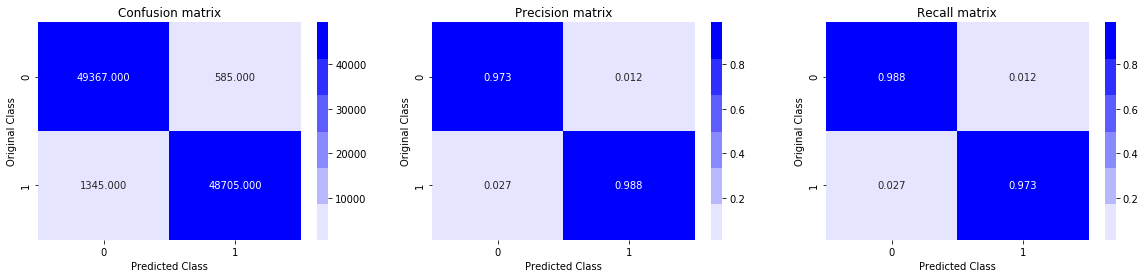

Test confusion_matrix


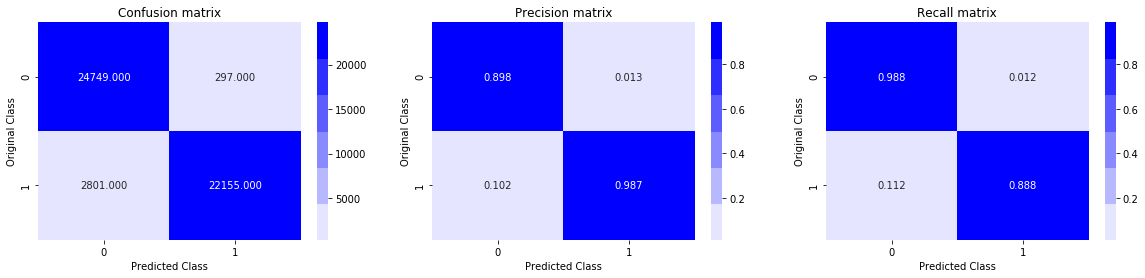

In [40]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)


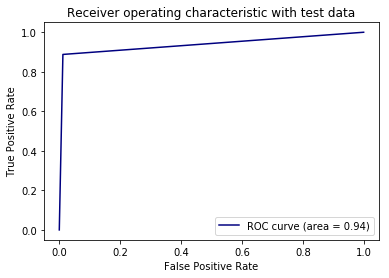

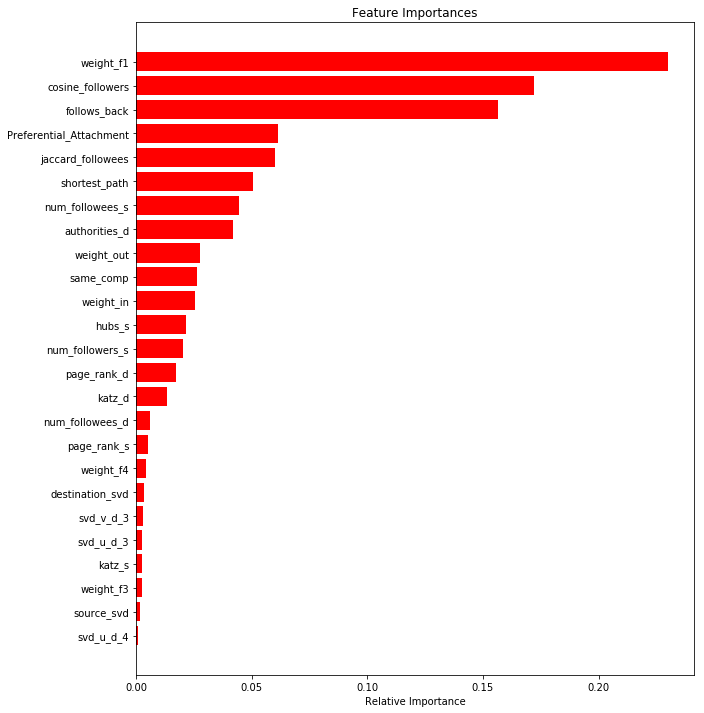

In [41]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

features = df_final_train.columns
importances = classifier.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## As we can see in the feature importance plot, all the three new features have contributed towards making model better.

In [0]:
y_train.nunique()

2

# help taken from : https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [0]:
import xgboost as xgb
from sklearn import metrics   #Additional scklearn functions
#from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.model_selection import cross_validate, learning_curve, GridSearchCV
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [0]:
def modelfit(alg, dtrain, y_train,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain.values, label=y_train.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain, y_train, eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain)
    dtrain_predprob = alg.predict_proba(dtrain)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y_train.values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, dtrain_predprob))
                    
    #feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    #feat_imp.plot(kind='bar', title='Feature Importances')
    #plt.ylabel('Feature Importance Score')
    
    features = dtrain.columns
    importances = alg.feature_importances_
    indices = (np.argsort(importances))[-25:]
    plt.figure(figsize=(10,12))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='r', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()



Model Report
Accuracy : 1
AUC Score (Train): 1.000000


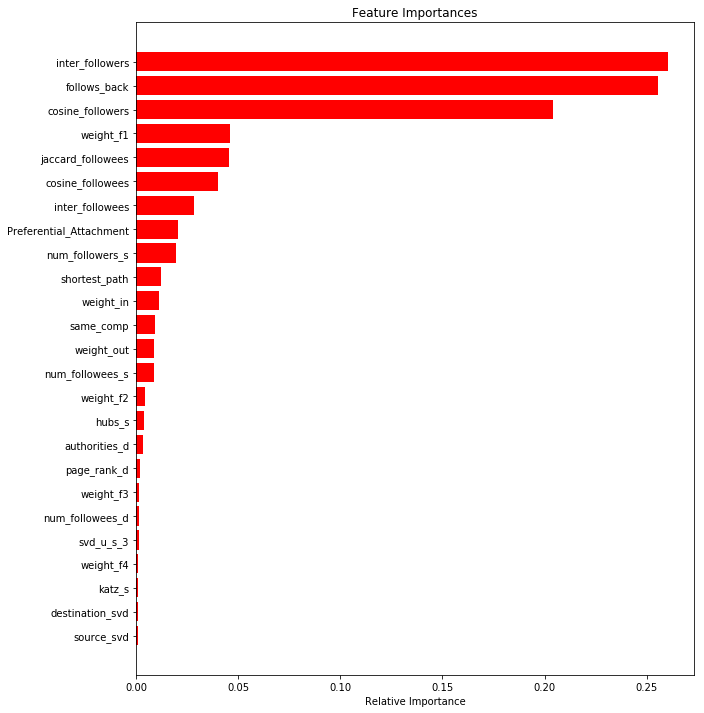

CPU times: user 33min 27s, sys: 7.93 s, total: 33min 35s
Wall time: 17min 31s


In [44]:
%%time
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)


modelfit(xgb1, df_final_train, y_train)

# Tune max_depth and min_child_weight

In [0]:
from sklearn.model_selection import GridSearchCV

In [46]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(df_final_train, y_train)



GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=5, min_child_weight=1,
                                     missing=None, n_estimators=140, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
             pre_dispatch='2*n_jobs', refit=True, retur

In [47]:
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([ 78.11917973,  78.24434996,  78.01218753, 122.07253237,
         122.17546806, 121.70129538, 168.78372078, 164.98793001,
         160.14246216, 213.56231709, 205.08777828, 179.38673625]),
  'mean_score_time': array([0.26178703, 0.22517505, 0.29801173, 0.39543762, 0.44642992,
         0.37241273, 0.53119764, 0.53018808, 0.5127728 , 0.59734001,
         0.62823038, 0.39192743]),
  'mean_test_score': array([0.99855148, 0.99853648, 0.99853059, 0.99906371, 0.99903838,
         0.9990563 , 0.99925931, 0.9992442 , 0.99922135, 0.99932226,
         0.99931352, 0.99930836]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[1, 3, 5, 1, 3, 5, 1, 3, 5, 1, 3, 5],
               mask=[False, False, False, False, False, Fals

In [0]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(df_final_train, y_train)

gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_


({'mean_fit_time': array([132.17170801, 128.58268175, 128.38554282, 153.39666319,
         156.23309836, 155.220784  , 181.40936341, 177.21912193,
         151.63105059]),
  'mean_score_time': array([0.40266252, 0.38275852, 0.35170074, 0.4420753 , 0.48212695,
         0.48885832, 0.53133035, 0.49037905, 0.35004964]),
  'mean_test_score': array([0.99886156, 0.99883996, 0.99884696, 0.99904471, 0.99902933,
         0.99903116, 0.99915218, 0.99913814, 0.99912669]),
  'mean_train_score': array([0.99908931, 0.99906778, 0.99907103, 0.99937409, 0.9993635 ,
         0.99936144, 0.99959044, 0.99958034, 0.99955722]),
  'param_max_depth': masked_array(data=[4, 4, 4, 5, 5, 5, 6, 6, 6],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[4, 5, 6, 4, 5, 6, 4, 5, 6],
               mask=[False, False, False, False, False, False, False, False,
      

In [0]:
param_test2b = {
 'min_child_weight':[6,8,10,12]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=4,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2b.fit(df_final_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=2, missing=None, n_estimators=140,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'min_child_weight': [6, 8, 10, 12]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)


Model Report
Accuracy : 0.9848
AUC Score (Train): 0.999014


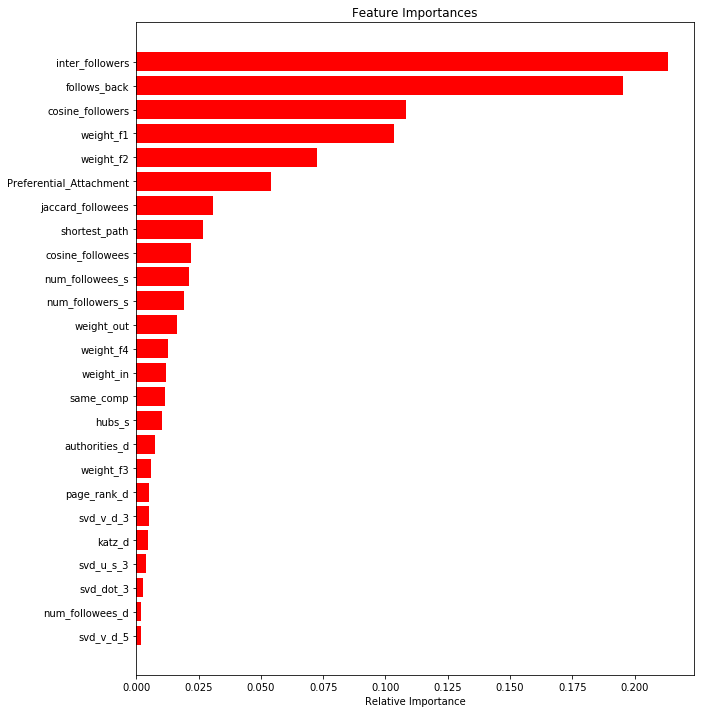

CPU times: user 6min 12s, sys: 1.63 s, total: 6min 14s
Wall time: 3min 16s


In [0]:
%%time
modelfit(gsearch2b.best_estimator_, df_final_train, y_train)
#gsearch2b.grid_scores_, gsearch2b.best_params_, gsearch2b.best_score_
gsearch2b.cv_results_, gsearch2b.best_params_, gsearch2b.best_score_

In [0]:
gsearch2b.cv_results_, gsearch2b.best_params_, gsearch2b.best_score_

({'mean_fit_time': array([131.51208415, 130.46986051, 130.87118387, 128.86180048]),
  'mean_score_time': array([0.41816707, 0.37426553, 0.35495749, 0.41335459]),
  'mean_test_score': array([0.99884696, 0.99886011, 0.99885412, 0.99884259]),
  'mean_train_score': array([0.99907103, 0.99907039, 0.99906765, 0.99905918]),
  'param_min_child_weight': masked_array(data=[6, 8, 10, 12],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'min_child_weight': 6},
   {'min_child_weight': 8},
   {'min_child_weight': 10},
   {'min_child_weight': 12}],
  'rank_test_score': array([3, 1, 2, 4], dtype=int32),
  'split0_test_score': array([0.99894329, 0.99893759, 0.99892578, 0.99892393]),
  'split0_train_score': array([0.99906489, 0.99904999, 0.99903721, 0.99904378]),
  'split1_test_score': array([0.99903194, 0.99899902, 0.99899283, 0.99902819]),
  'split1_train_score': array([0.99903809, 0.99899876, 0.99899907, 0.99903131]),
  'split2_tes

# Tune gamma

In [0]:
%%time
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=9,
 min_child_weight=8, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(df_final_train, y_train)
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

CPU times: user 2min 13s, sys: 967 ms, total: 2min 14s
Wall time: 27min 45s


In [0]:
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

({'mean_fit_time': array([255.51364703, 251.17548695, 251.00310431, 251.48400154,
         214.45768657]),
  'mean_score_time': array([0.53122215, 0.50875921, 0.6110631 , 0.57809711, 0.49489088]),
  'mean_test_score': array([0.99927462, 0.99927044, 0.99926602, 0.99928731, 0.99928397]),
  'mean_train_score': array([0.99988942, 0.99988746, 0.99988803, 0.99989316, 0.99988452]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'rank_test_score': array([3, 4, 5, 1, 2], dtype=int32),
  'split0_test_score': array([0.99931465, 0.99928211, 0.99931602, 0.99933217, 0.9993278 ]),
  'split0_train_score': array([0.99988839, 0.99988493, 0.99988854, 0.99989027, 0.99988113]),
  'split1_test_score': array([0.99936423, 0.99939845, 0.99938982, 0.99940371, 0.99939474]),
  'split


Model Report
Accuracy : 0.9997
AUC Score (Train): 1.000000


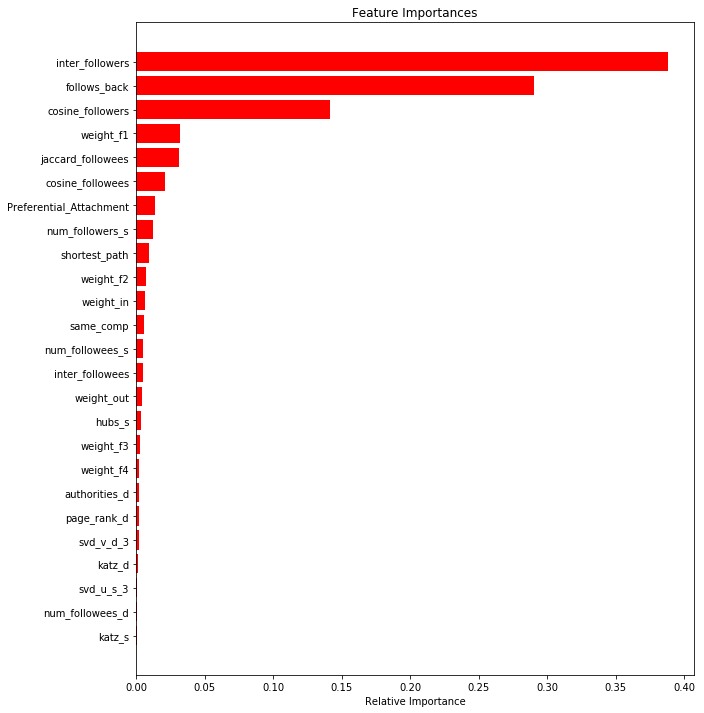

In [0]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=9,
 min_child_weight=8,
 gamma=0.3,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb2, df_final_train, y_train)

#  Tune subsample and colsample_bytree

In [56]:
%%time
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=9,
 min_child_weight=8, gamma=0.3, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)

gsearch4.fit(df_final_train, y_train)



CPU times: user 2min 37s, sys: 1.28 s, total: 2min 38s
Wall time: 1h 17min 41s


In [0]:
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

({'mean_fit_time': array([128.35479522, 110.54089823, 114.88536386, 118.16604095,
         120.9758719 , 128.03011818, 133.07303467, 135.50618873,
         134.79336476, 142.0484189 , 146.12940063, 150.3775949 ,
         149.26545868, 157.23077812, 163.36556964, 164.79058442]),
  'mean_score_time': array([0.33173246, 0.3169013 , 0.3274982 , 0.33410215, 0.32927413,
         0.33495288, 0.30037684, 0.32574058, 0.35323286, 0.35304565,
         0.32028236, 0.34849763, 0.31548738, 0.31135755, 0.31493134,
         0.29831481]),
  'mean_test_score': array([0.9992755 , 0.99928815, 0.99929458, 0.99930116, 0.99928037,
         0.99929325, 0.99930742, 0.99929537, 0.99928479, 0.99929447,
         0.99932737, 0.99930874, 0.99927658, 0.99931563, 0.99931174,
         0.99932162]),
  'mean_train_score': array([0.99993713, 0.99995258, 0.99996103, 0.99996581, 0.99993966,
         0.99994899, 0.99995681, 0.99996127, 0.99993834, 0.99994943,
         0.99995666, 0.99995561, 0.99994001, 0.99995025, 0.999955

In [0]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,85,3)],
 'colsample_bytree':[i/100.0 for i in range(75,85,3)]
}

gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=9,
 min_child_weight=9, gamma=0.3, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch5.fit(df_final_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.3, learning_rate=0.1,
       max_delta_step=0, max_depth=9, min_child_weight=9, missing=None,
       n_estimators=177, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'subsample': [0.75, 0.78, 0.81, 0.84], 'colsample_bytree': [0.75, 0.78, 0.81, 0.84]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [0]:
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

({'mean_fit_time': array([302.92039347, 293.8115057 , 298.97528057, 291.18409028,
         303.66260371, 304.86778102, 309.14104762, 300.5765748 ,
         308.78340092, 307.74335113, 313.13925533, 314.09605527,
         314.2329844 , 319.58474565, 322.71728125, 299.28868232]),
  'mean_score_time': array([0.77026658, 0.76972566, 0.76679802, 0.7011096 , 0.7240437 ,
         0.75406442, 0.77312388, 0.65594654, 0.73847847, 0.82006764,
         0.77934847, 0.75223355, 0.82994165, 0.77469034, 0.75916128,
         0.50898991]),
  'mean_test_score': array([0.99930179, 0.99930374, 0.99930201, 0.99930544, 0.99928977,
         0.99930637, 0.99929668, 0.9992925 , 0.99930068, 0.99929222,
         0.9993169 , 0.9993124 , 0.99931246, 0.99930518, 0.99931516,
         0.9993157 ]),
  'mean_train_score': array([0.99993975, 0.9999444 , 0.99994314, 0.99994479, 0.99994392,
         0.99994312, 0.99994643, 0.99994633, 0.99994049, 0.99994406,
         0.99994492, 0.99994489, 0.99994467, 0.99994467, 0.999945

# Tuning Regularization Parameters

In [0]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 10]
}

gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=9,
 min_child_weight=8, gamma=0.3, subsample=0.81, colsample_bytree=0.81, 
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)

gsearch6.fit(df_final_train, y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.81, gamma=0.3, learning_rate=0.1,
       max_delta_step=0, max_depth=9, min_child_weight=8, missing=None,
       n_estimators=177, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.81),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [0]:
gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_

({'mean_fit_time': array([154.8880085 , 154.36676297, 154.20631671, 154.46937642,
         137.4012804 ]),
  'mean_score_time': array([0.3276134 , 0.32364383, 0.32347493, 0.34764633, 0.28823824]),
  'mean_test_score': array([0.99930899, 0.99930051, 0.99931045, 0.99931806, 0.99920924]),
  'mean_train_score': array([0.99995352, 0.99995492, 0.99995401, 0.99995847, 0.99977171]),
  'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1, 10],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 1e-05},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.1},
   {'reg_alpha': 1},
   {'reg_alpha': 10}],
  'rank_test_score': array([3, 4, 2, 1, 5], dtype=int32),
  'split0_test_score': array([0.99934684, 0.99933189, 0.99932681, 0.99936777, 0.99925469]),
  'split0_train_score': array([0.99995661, 0.99995201, 0.99995233, 0.99996283, 0.99976855]),
  'split1_test_score': array([0.99942358, 0.99939777, 0.99942164, 0.99940697

In [0]:
param_test7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}

gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=9,
 min_child_weight=8, gamma=0.3, subsample=0.81, colsample_bytree=0.81,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)

gsearch7.fit(df_final_train, y_train)



GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.81, gamma=0.3, learning_rate=0.1,
       max_delta_step=0, max_depth=9, min_child_weight=8, missing=None,
       n_estimators=177, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.81),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [0]:
gsearch7.cv_results_, gsearch7.best_params_, gsearch7.best_score_

({'mean_fit_time': array([154.77048984, 152.64919739, 153.20305319, 152.12401829,
         138.50641689]),
  'mean_score_time': array([0.30539746, 0.31285195, 0.32558684, 0.35305657, 0.29121881]),
  'mean_test_score': array([0.99930875, 0.99930463, 0.99930707, 0.99930051, 0.99932117]),
  'mean_train_score': array([0.99995334, 0.99995396, 0.99995513, 0.99995492, 0.9999541 ]),
  'param_reg_alpha': masked_array(data=[0, 0.001, 0.005, 0.01, 0.05],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 0},
   {'reg_alpha': 0.001},
   {'reg_alpha': 0.005},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.05}],
  'rank_test_score': array([2, 4, 3, 5, 1], dtype=int32),
  'split0_test_score': array([0.99934684, 0.99934903, 0.99933144, 0.99933189, 0.99935979]),
  'split0_train_score': array([0.99995661, 0.99995426, 0.99995386, 0.99995201, 0.99995109]),
  'split1_test_score': array([0.99942234, 0.99940431, 0.99942849, 0.


Model Report
Accuracy : 0.9989
AUC Score (Train): 0.999994


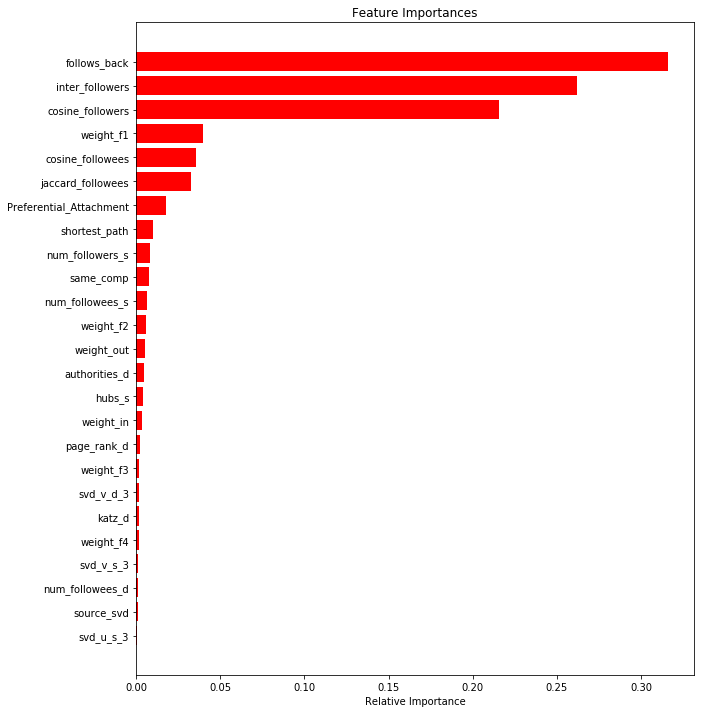

CPU times: user 20min 13s, sys: 4.42 s, total: 20min 18s
Wall time: 10min 35s


In [48]:
%%time
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=9,
 min_child_weight=8,
 gamma=0.3,
 subsample=0.81,
 colsample_bytree=0.81,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27, n_jobs=-1)
modelfit(xgb3, df_final_train, y_train)

In [49]:
%%time
classifier = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=9,
 min_child_weight=8,
 gamma=0.3,
 subsample=0.81,
 colsample_bytree=0.81,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27, 
 n_jobs=-1)

classifier.fit(df_final_train, y_train)

CPU times: user 12min 8s, sys: 1.87 s, total: 12min 10s
Wall time: 6min 18s


In [50]:
y_train_pred = classifier.predict(df_final_train)
y_test_pred = classifier.predict(df_final_test)

from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 1.0
Test f1 score 0.9239413750373883


In [0]:
import pickle
pickle.dump(classifier, open("/content/drive/My Drive/Applied AI/Facebook Friend Recommendation using Graph Mining/xgb_fine_tuned_clf1_1.pickle.dat", "wb"))


In [0]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()


Train confusion_matrix


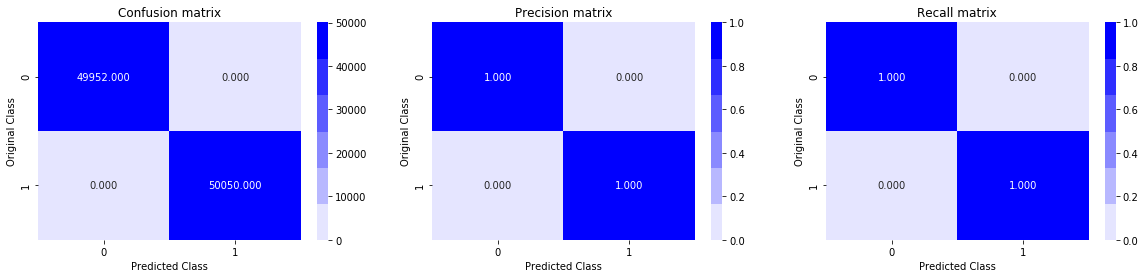

Test confusion_matrix


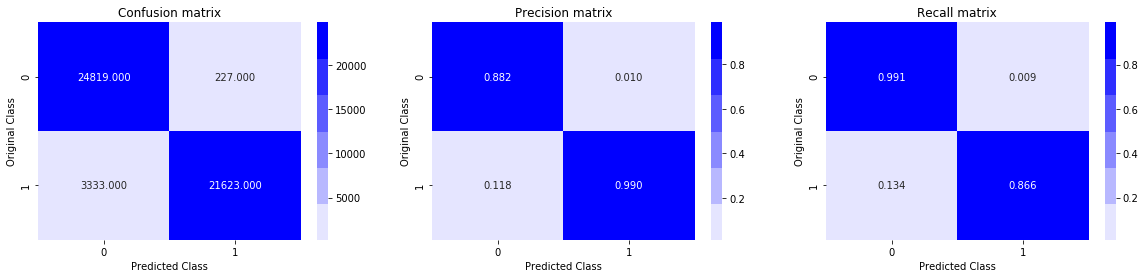

In [53]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)


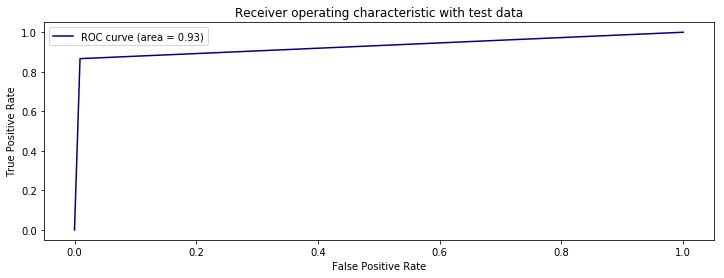

In [54]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()



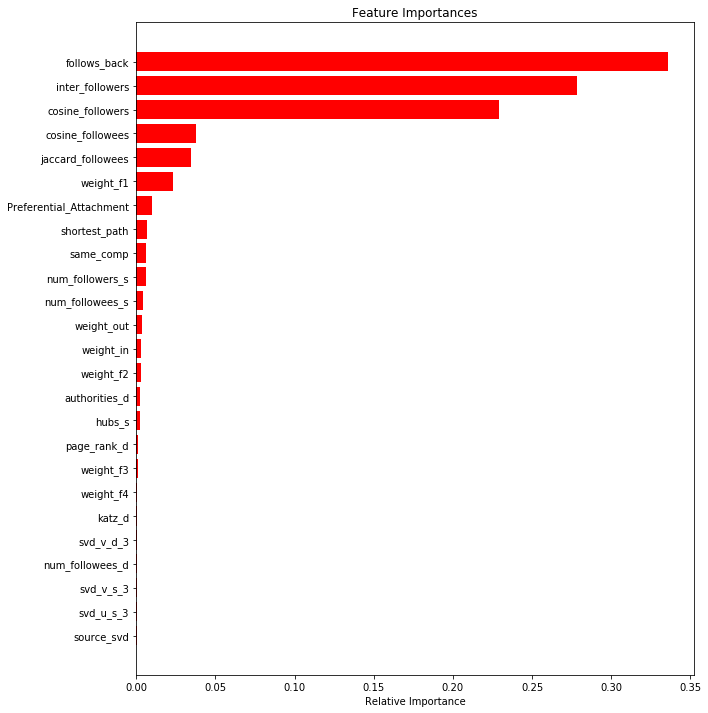

In [55]:
features = df_final_train.columns
importances = classifier.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


In [57]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["ALgorithm", "Train F1 Score","Test F1 Score"]

x.add_row(["Random Forest", "0.9652533106548414","0.9241678239279553"])
x.add_row(["XGBoost (without fine tuning)", "0.9805717737064626","0.9346523793452582"])
x.add_row(["XGBoost (with fine tuning)", "1.0","0.9239413750373883"])
print(x)

+-------------------------------+--------------------+--------------------+
|           ALgorithm           |   Train F1 Score   |   Test F1 Score    |
+-------------------------------+--------------------+--------------------+
|         Random Forest         | 0.9652533106548414 | 0.9241678239279553 |
| XGBoost (without fine tuning) | 0.9805717737064626 | 0.9346523793452582 |
|   XGBoost (with fine tuning)  |        1.0         | 0.9239413750373883 |
+-------------------------------+--------------------+--------------------+


# Conclusion
1. The performance of XGBoost is better as compared with the Random Forest(in the provided file).
2. The newly added featureas have the relative feature importance as given order Preferential_Attachment, destination_svd, source_svd in the without fine tuned XgBoost.
3. But after fine tunning of XGBoost the destination_svd, source_svd features lost their relative feature importance and the test F1 score is depreceated.